In [10]:
library("adegenet")
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
library(ggpubr)
setwd("~/Omega/USM PhD/Projects/Active/Yellowfin Tuna/Popgen/Analyses/nonkin/DAPC")


## Setup the data

In [11]:
i <- "neutral"
infile <- paste0("YFT.snp.kinrm.pcrelate.", i, ".gen")
data <- read.genepop(infile, ncode = 3L)
PopNames <- c("ATL","GOM","IVC", "SEN", "TX", "VZ")
popNames(data) <- PopNames
metadata <- read_table("metadata.txt", col_names = TRUE)


 Converting data from a Genepop .gen file to a genind object... 


File description:  genepop generated from PopData by PopGen.jl 

...done.




── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  population = col_character(),
  year = col_double()
)




## K-means clustering

In [12]:
maxK <- 7
myMat <- matrix(nrow=50, ncol=maxK)
colnames(myMat) <- 1:maxK
for(i in 1:nrow(myMat)){
  grp <- find.clusters(data, n.pca = 298, choose.n.clust = FALSE,  max.n.clust = maxK)
  myMat[i,] <- grp$Kstat
  #print(grp$Kstat)
}

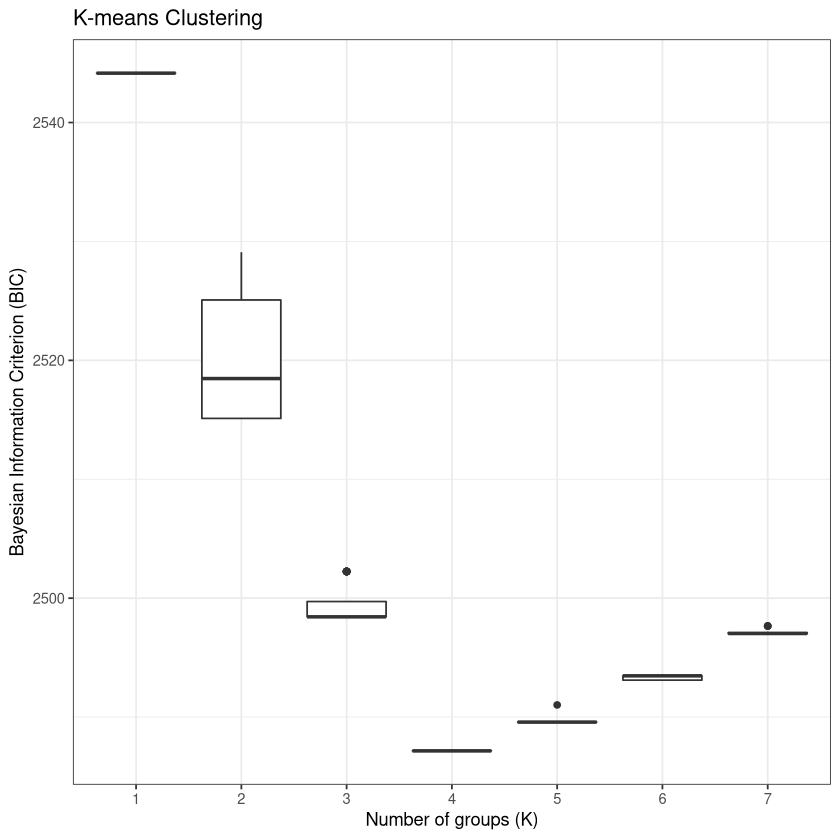

In [13]:
k_df <- reshape2::melt(myMat)
colnames(k_df)[1:3] <- c("Group", "K", "BIC")
k_df$K <- as.factor(k_df$K)

k_plot <- k_df %>% 
  ggplot(aes(x = K, y = BIC)) +
  geom_boxplot() +
  theme_bw() +
  labs(title = "K-means Clustering") +
  ylab("Bayesian Information Criterion (BIC)") +
  xlab("Number of groups (K)")
k_plot

## DAPC

In [14]:
by_location <- dapc(data, pop = metadata$population, perc.pca = 85, n.da = 4)


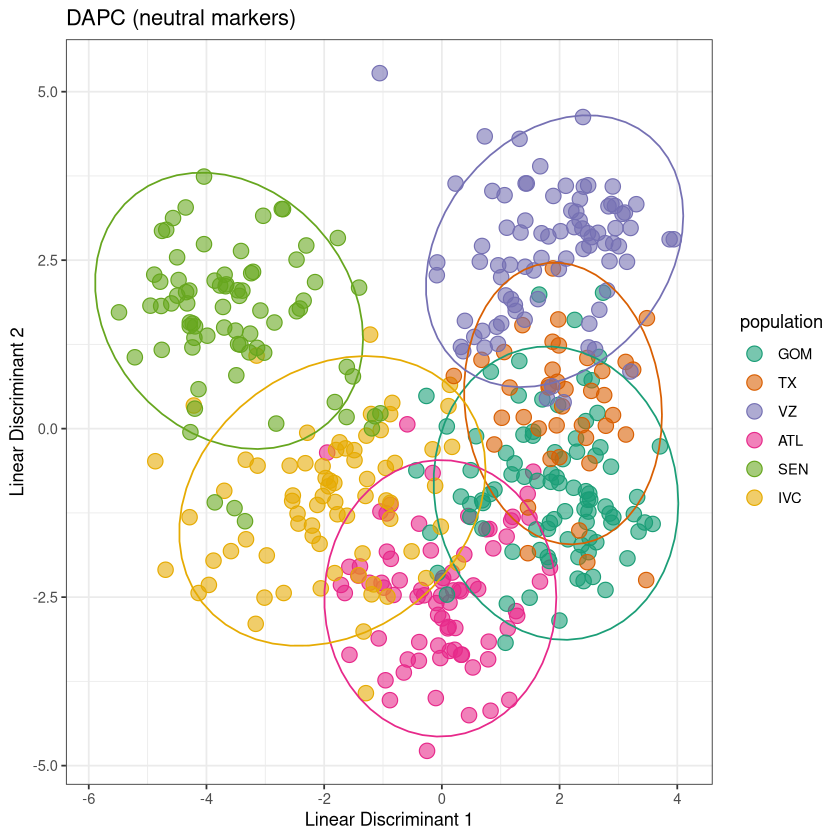

In [15]:
my_pal <- RColorBrewer::brewer.pal(n=6, name = "Dark2")

dapc_l <- by_location
my_df <- as.data.frame(dapc_l$ind.coord)
my_df$Group <- dapc_l$grp

df <- as.data.frame(by_location$ind.coord)
df <- cbind(metadata$name, metadata$population, df)
names(df) <- c("name", "population", "LD1", "LD2", "LD3", "LD4")
df$population <- df$population <- factor(df$population, levels = c("GOM", "TX", "VZ", "ATL", "SEN", "IVC"), ordered = TRUE)


dapc_plot <- df %>% 
  ggplot(aes(x = LD1, y = LD2, color = population, fill = population)) +
  geom_point(size = 4, shape = 21) +
  stat_ellipse(show.legend = FALSE) +
  labs(title = "DAPC (neutral markers)") +
  xlab("Linear Discriminant 1") +
  ylab("Linear Discriminant 2") +
  theme_bw() +
  scale_color_manual(values=c(my_pal)) +
  scale_fill_manual(values=c(paste(my_pal, "96", sep = "")))
dapc_plot

## Structure-like plots

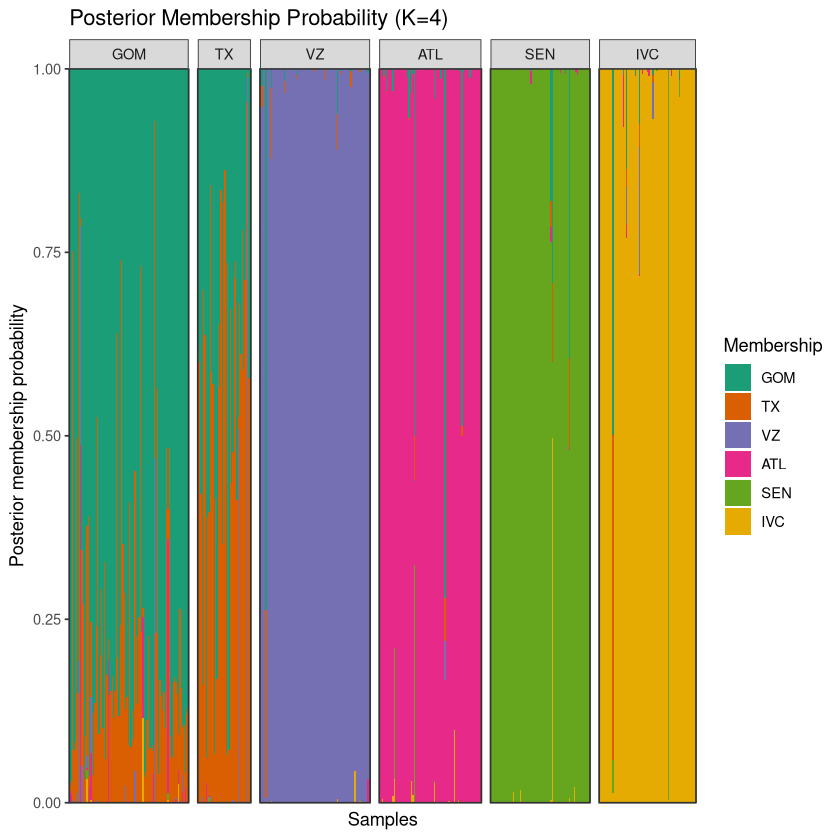

In [16]:
tmp <- as.data.frame(dapc_l$posterior)
tmp <- cbind(metadata$name, metadata$population, tmp)[,1:8] #drop redundant col
names(tmp) <- c("name", "origin", "ATL","GOM","IVC","SEN","TX","VZ")
tmp <- pivot_longer(tmp, c(-name, -origin), names_to = "population", values_to = "posterior")
tmp$population <- factor(tmp$population, levels = c("GOM", "TX", "VZ", "ATL", "SEN", "IVC"), ordered = TRUE)
tmp$origin <- factor(tmp$origin, levels = c("GOM", "TX", "VZ", "ATL", "SEN", "IVC"), ordered = TRUE)


posterior_plot <- tmp %>% 
  ggplot(aes(x = name, y = posterior, fill = population)) +
  geom_bar(stat = "identity", width = 1.0) +
  scale_fill_manual(values=c(my_pal)) +
  labs(title = "Posterior Membership Probability (K=4)") +
  ylab("Posterior membership probability") +
  xlab("Samples") +
  facet_grid(~origin, scales = "free_x", space = "free" ) + 
  theme_bw() +
  guides(fill=guide_legend(title="Membership")) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
  coord_cartesian(ylim = c(0, 1), expand = FALSE, clip = "off")
posterior_plot

## Arrange and Save

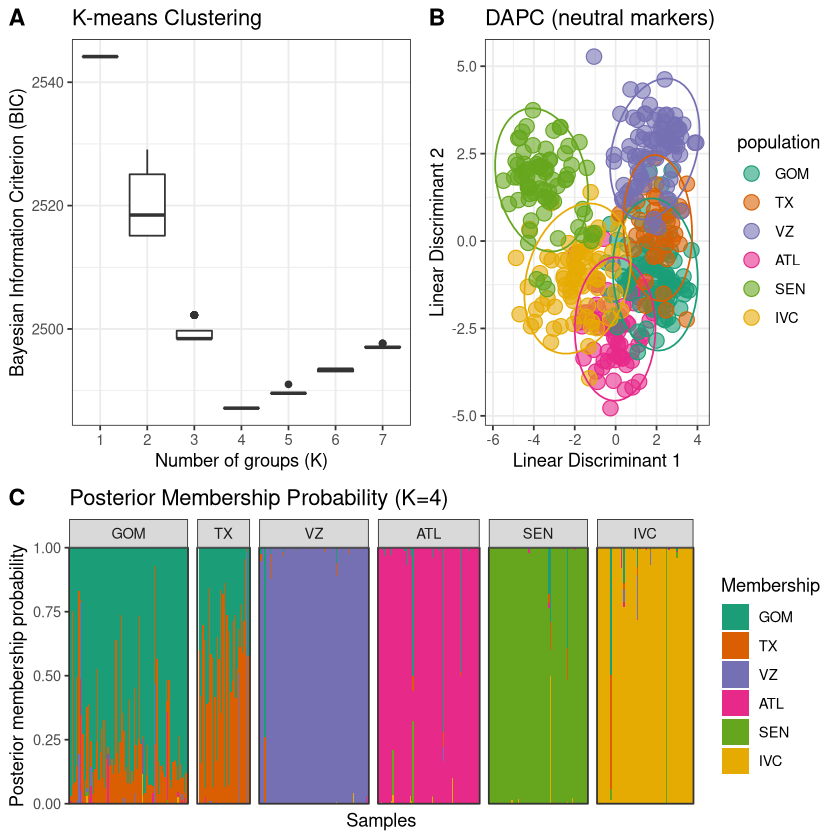

In [17]:
ggarrange(
  ggarrange(
    k_plot,
    dapc_plot,
    ncol = 2, labels = c("A", "B")
  ),
  posterior_plot,
  nrow = 2,
  labels = c("", "C"),
  heights = c(2, 1.5)
)

In [18]:
ggsave("DAPC_neutral.png", height = 6, width = 11, units = "in")